<a href="https://colab.research.google.com/github/Apple03244/Colaboratory/blob/main/wide%26deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import google.colab as colab
import pandas as pd

In [2]:
method=colab.files
files=method.upload()

Saving train.csv to train.csv


In [3]:
data=pd.read_csv('/content/train.csv')

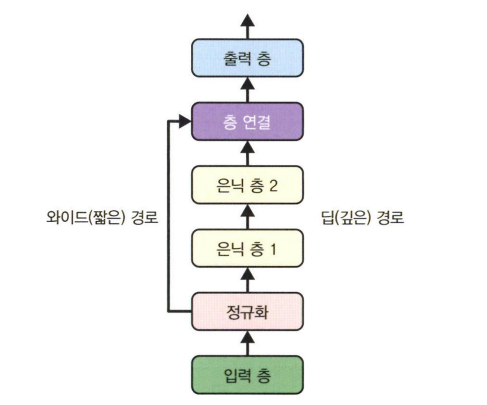

## Wide&Deep 경로 두가지 모두 충족시키는 모델

- 필요 이유 : 단순한 패턴과 복잡한 패턴을 모두 학습시키기가 가능해짐
- squance 모델만 이용할 경우 단순한 패턴까지도 모든 네트워크를 지나야하기 때문에 오히려 어려워질수 있음

In [4]:
import tensorflow as ts
import sklearn.pipeline as skpip
import sklearn.model_selection as skmod
import sklearn.preprocessing as skpre
ts.random.set_seed(10)

In [5]:
data["일시"]=data[["일시"]].apply(lambda x:pd.to_datetime(x))
use_data=data.fillna(0)
target='평균기온'
feature=use_data.columns.difference(["일시",target])

In [6]:
train_data=use_data[use_data["일시"].apply(lambda x:x.year<2020)]
test_data=use_data[use_data["일시"].apply(lambda x:x.year>=2020)]

### step 1. 우선 모델을 만들어 이해해보자
### type 1. All features -> Deep & Wide

In [7]:
ts.random.set_seed(10)
nomalizer=ts.keras.layers.Normalization(input_shape=use_data.shape[1:])
hidden_layer1=ts.keras.layers.Dense(30,activation="relu")
hidden_layer2=ts.keras.layers.Dense(30,activation="relu")
concat_layer=ts.keras.layers.Concatenate()
output_layer=ts.keras.layers.Dense(1)

In [8]:
input_=ts.keras.layers.Input(shape=[len(feature),]) # input 객체
nomal=nomalizer(input_)
hidden1=hidden_layer1(nomal)
hidden2=hidden_layer2(hidden1)
concat=concat_layer([nomal,hidden2])
output=output_layer(concat)

In [9]:
model=ts.keras.Model(inputs=[input_],outputs=[output])

In [10]:
optimizer=ts.keras.optimizers.Adam(learning_rate=1e-6)
loss=ts.keras.losses.mae
model.compile(loss=loss,optimizer=optimizer,metrics=["RootMeanSquaredError"])

In [11]:
nomalizer.adapt(train_data[feature]) # 평균과 분산을 줘야한다

In [12]:
running_history=model.fit(x=train_data[feature],y=train_data[target],epochs=30,validation_data=[test_data[feature],test_data[target]])

Epoch 1/30
685/685 [==============================] - 6s 6ms/step - loss: 13.4752 - root_mean_squared_error: 16.0236 - val_loss: 14.3793 - val_root_mean_squared_error: 16.7622
Epoch 2/30
685/685 [==============================] - 5s 7ms/step - loss: 13.4564 - root_mean_squared_error: 16.0013 - val_loss: 14.3578 - val_root_mean_squared_error: 16.7371
Epoch 3/30
685/685 [==============================] - 4s 6ms/step - loss: 13.4377 - root_mean_squared_error: 15.9789 - val_loss: 14.3362 - val_root_mean_squared_error: 16.7119
Epoch 4/30
685/685 [==============================] - 4s 5ms/step - loss: 13.4188 - root_mean_squared_error: 15.9564 - val_loss: 14.3145 - val_root_mean_squared_error: 16.6867
Epoch 5/30
685/685 [==============================] - 6s 9ms/step - loss: 13.3998 - root_mean_squared_error: 15.9338 - val_loss: 14.2928 - val_root_mean_squared_error: 16.6614
Epoch 6/30
685/685 [==============================] - 2s 3ms/step - loss: 13.3808 - root_mean_squared_error: 15.9112 - v

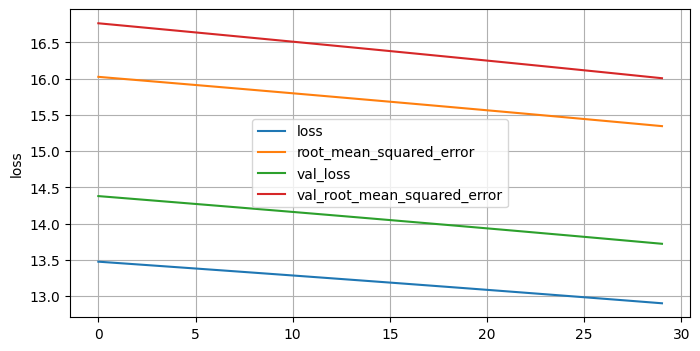

In [13]:
import matplotlib.pyplot as plt
import seaborn as sb
runned_data=pd.DataFrame(running_history.history)
plt.figure(figsize=(8,4))
for col in runned_data.columns:
  sb.lineplot(x=runned_data.index,y=runned_data[col],label=col)
plt.grid()
plt.show()

In [14]:
import sklearn.metrics as skmet
pred_y=model.predict(x=test_data[feature])
skmet.mean_absolute_error(y_true=test_data[target],y_pred=pred_y)

35/35 [==============================] - 0s 2ms/step


13.72171469319384

### type 2. Some of feature -> Deep
이럴 경우 우리는 경로를 두개로 만들어볼 수 있다

In [15]:
# 최고기온, 최저기온을 wide 층으로 넣어보겠다.
# 그 외에는 deep network를 지나갈것이다.
input_wide=ts.keras.layers.Input(shape=[2])
input_deep=ts.keras.layers.Input(shape=[len(feature)-2])

# 1-1.정규층
normalizer1=ts.keras.layers.Normalization() # 위와 동일하게 만들어놓고 지나가게 해야한다. why? 평균과 분산을 저장하기 위한 곳이기때문
normalizer2=ts.keras.layers.Normalization()
# 1-2.정규화 시키기
norm_wide=normalizer1(input_wide)
norm_deep=normalizer2(input_deep)
# 2-1.은닉층(위의 예시랑 동일하게 진행)
hidden_layer1=ts.keras.layers.Dense(30,activation="relu")
hidden_layer2=ts.keras.layers.Dense(30,activation="relu")
# 2-2.은닉층 지나기
deep_1=hidden_layer1(norm_deep)
passed_deep=hidden_layer2(deep_1)
# 3-1.합치기
concate_layer=ts.keras.layers.Concatenate()
concate=concate_layer([norm_wide,passed_deep])
# 4-1.내보내기
output_layer=ts.keras.layers.Dense(1)
output=output_layer(concate)

In [16]:
# 5-1.모델 만들어 컴파일
model2=ts.keras.Model(inputs=(input_wide,input_deep),outputs=output)
optimizer=ts.keras.optimizers.SGD(learning_rate=0.01)
loss=ts.keras.losses.mse
model2.compile(loss=loss,optimizer=optimizer,metrics=["RootMeanSquaredError"])

In [34]:
# 6-1. 모델 학습시
train_two_type=(train_data[["최고기온","최저기온"]],train_data[feature.difference(["최고기온","최저기온"])])
test_two_type=(test_data[["최고기온","최저기온"]],test_data[feature.difference(["최고기온","최저기온"])])

In [36]:
running_history2=model2.fit(x=train_two_type,y=train_data[target],epochs=30,validation_data=test_two_type)

Epoch 1/30


TypeError: ignored

0       -1.6
1       -1.9
2        4.0
3        7.5
4       -4.6
        ... 
21910   -1.7
21911    1.1
21912    3.8
21913    2.7
21914   -7.9
Name: 평균기온, Length: 21915, dtype: float64